# 5.2 3D Reconstruction with Pairwise Alignment on Drosophila Data

In this tutorial, you will learn how to reconstruct a 3D spatial transcriptomics by aligning the consecutive spatial transcriptomics slices serially using rigid alignment. Considering the ST technology, slice quality, etc., alignment is not always perfect at the same parameter settings. Thus we also provide guidance for user on how to check and correct errors in alignment.

In [53]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import dynamo as dyn
import numpy as np
import anndata as as

# Uncomment the following if running on the server
import pyvista as pv
pv.start_xvfb()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Running this notebook on:  cuda
Last run with spateo version: 1.1.0.dev44+cbea5b3


## Loading the Data

In this tutorial, we will use the Drosophila dataset at stages E8-9h, obtained using the Stereo-Seq technique. You can download the raw data from [Flysta3D](https://db.cngb.org/stomics/flysta3d/). After downloading, be sure to place the data in the appropriate directory.

In [104]:
adata = st.read('./data/Drosophila_E8-9h.h5ad')

adata

AnnData object with n_obs × n_vars = 22483 × 2004
    obs: 'z_height', 'anno_tissue'
    obsm: 'spatial'

## Preprocessing

In the first step, we perform preprocessing. Here, we use Dynamo's preprocessing framework, which is simple and fast. 

In [105]:
from dynamo.preprocessing import Preprocessor
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 4487 outlier cells
|-----? No layers exist in adata, skipp filtering by shared counts
|-----------> filtered out 1307 outlier genes
|-----? Transforming adata.X from int to float32 for normalization. If you want to disable this, set `transform_int_to_float` to False.
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [1.1288s]


We plot the UMAP

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [23.8449s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering anno_tissue by stack threshold when stacking color because it is not a numeric type


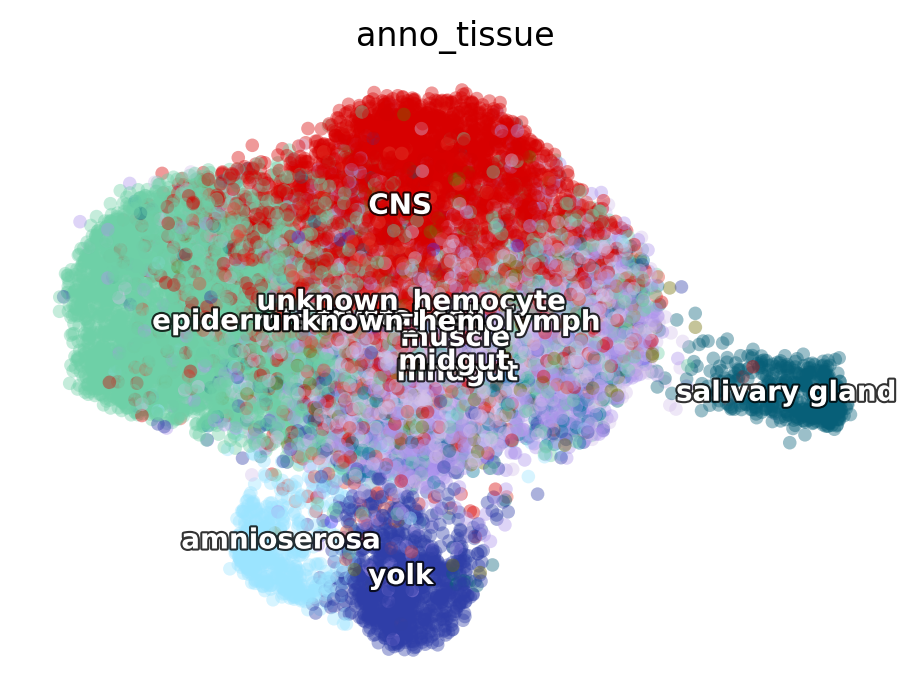

In [106]:
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color='anno_tissue', pointsize=0.2, alpha=0.4)

Next, we divide the adata into multiple slices based on some label information, such as height.

In [107]:
slice_label = adata.obs['z_height'].cat.categories
slices = [adata[adata.obs['z_height'] == s] for s in slice_label]

The 2D visualization plot show the initial spatial coordinate.

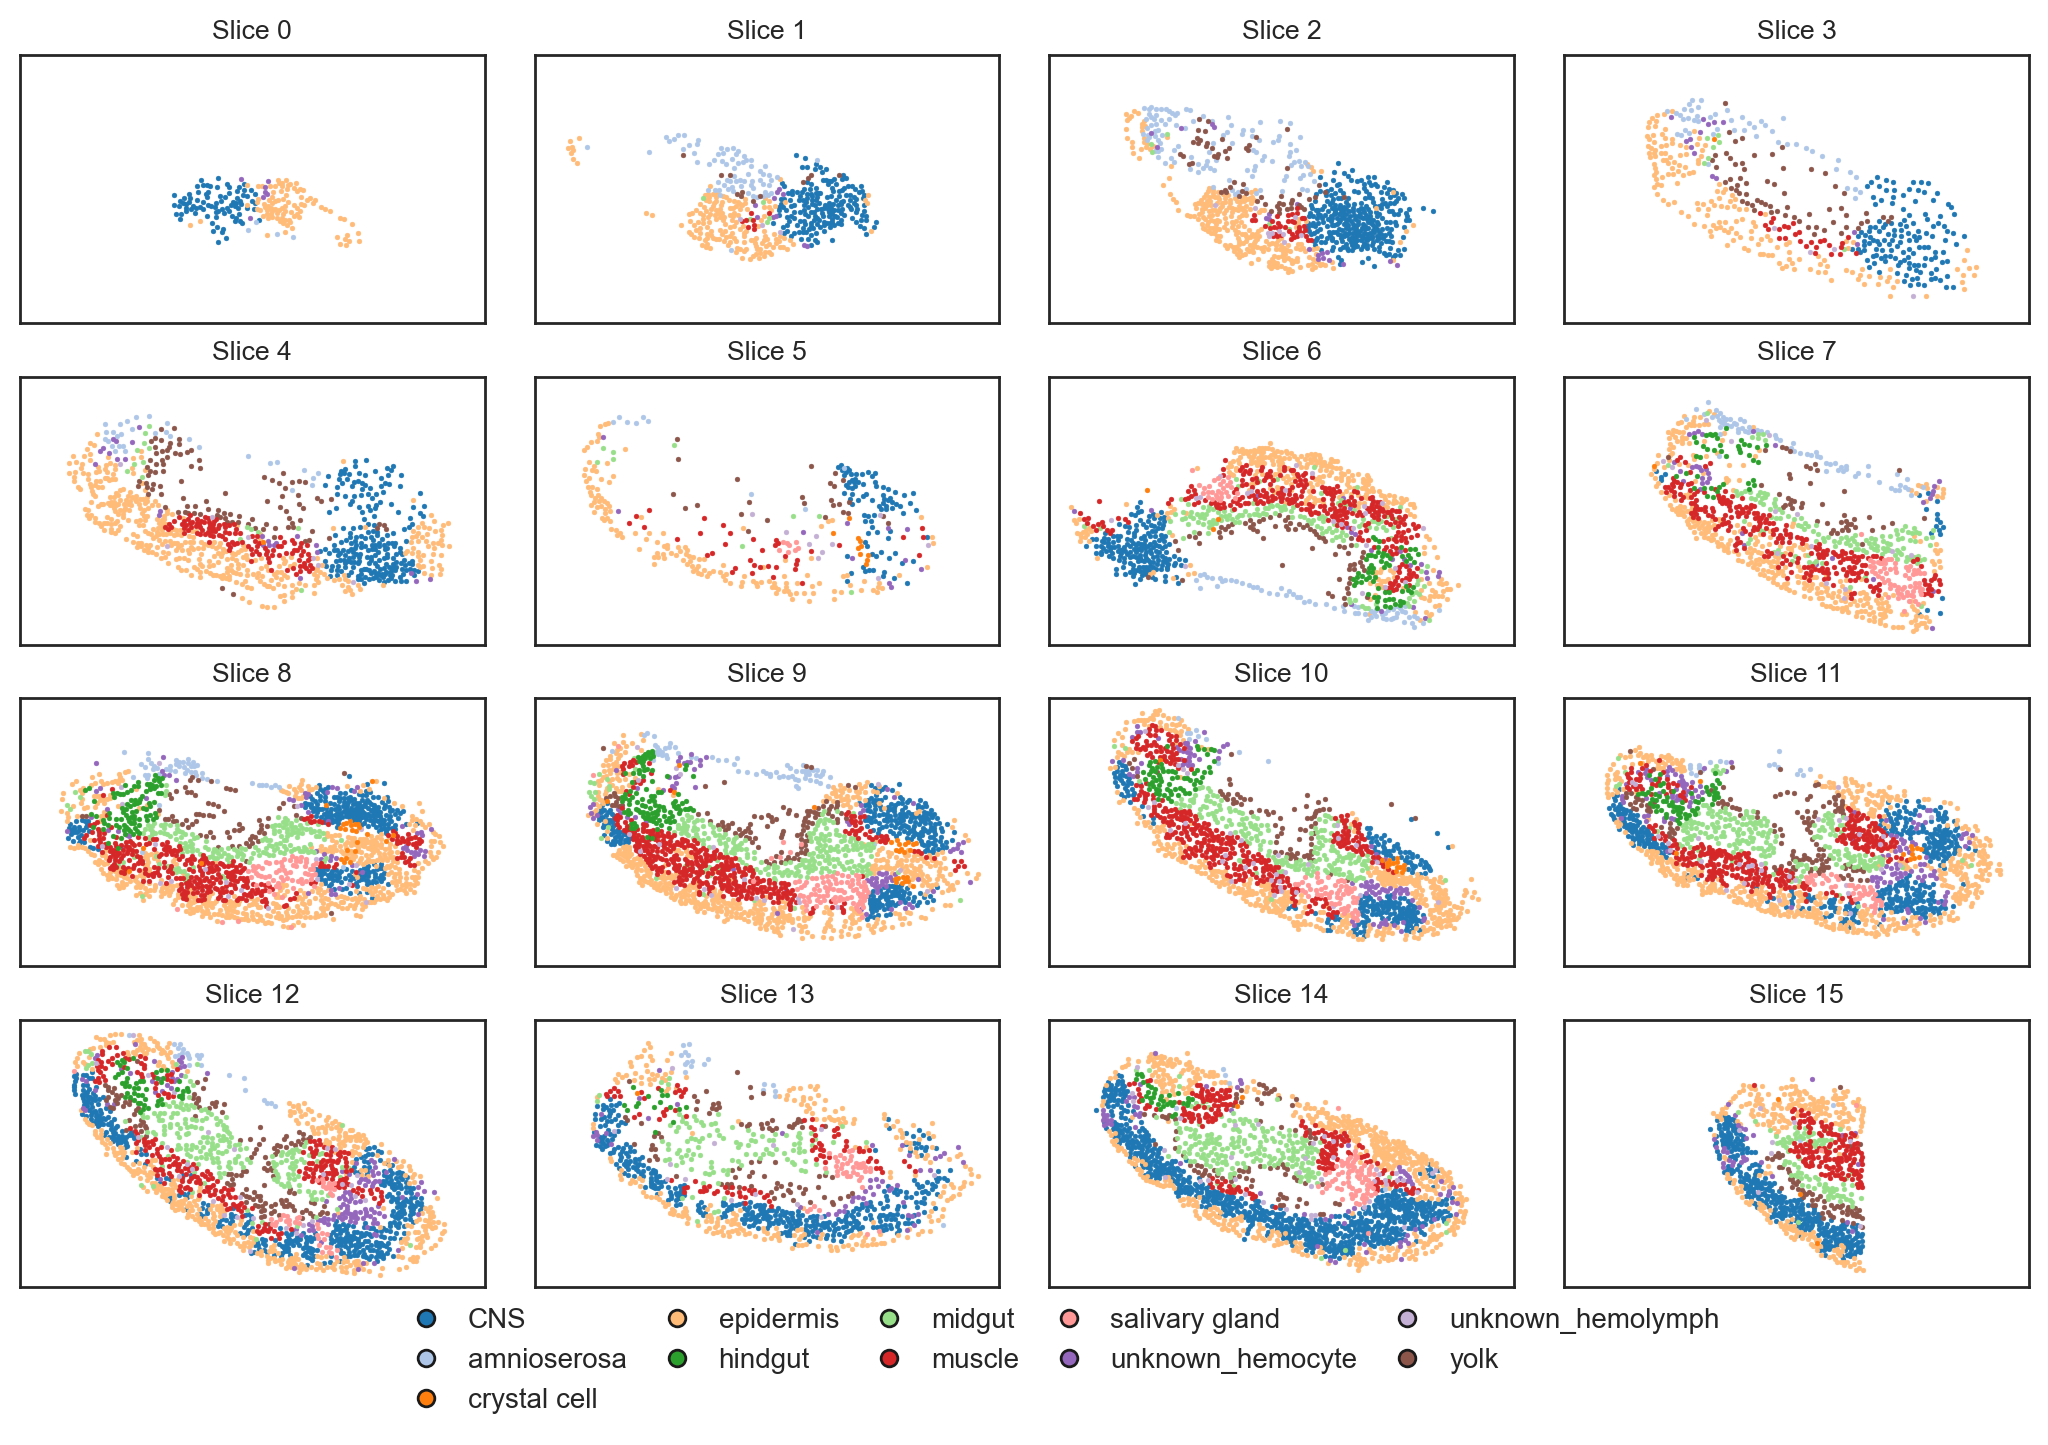

In [108]:
spatial_key = 'spatial'
cluster_key = 'anno_tissue'

st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=2,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -6, 'frameon': False},
)

## Pairwise rigid alignment

Next, we calculate the spatial transformation between each pair of adjacent slices through pairwise rigid alignment and save these transformations in ``transformation`` (with a length of ``len(slices)-1``) using ``st.align.morpho_align_transformation``. 

In [110]:
key_added = 'align_spatial'
transformation = st.align.morpho_align_transformation(
    models=slices,
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
)

|-----> [Models alignment based on morpho.] in progress: 100.0000%
|-----> [Models alignment based on morpho.] finished [12.4828s]


The output transformations include both a rotation matrix and a translation matrix

In [153]:
transformation[0]

{'Rotation': array([[-0.9428654 , -0.33317396],
        [ 0.33317396, -0.9428654 ]], dtype=float32),
 'Translation': array([872.21326, 134.27649], dtype=float32)}

We then align these spatial transformations to unify the coordinate system of all slices, aligning them with the first slice (which remains unchanged).

In [152]:
aligned_slices = st.align.morpho_align_apply_transformation(
    models=slices,
    spatial_key=spatial_key,
    key_added=key_added,
    transformation=transformation,
)

|-----> [Models alignment based on morpho, applying transformation.] in progress: 100.0000%
|-----> [Models alignment based on morpho, applying transformation.] finished [0.0099s]


## Check the pairwise alignment results

We need to verify whether the pairwise alignment results are correct, as our algorithm cannot guarantee a 100% success rate with default parameters. If errors occur, parameter tuning may be necessary. Here, we visualize the pairwise alignment results for inspection. 

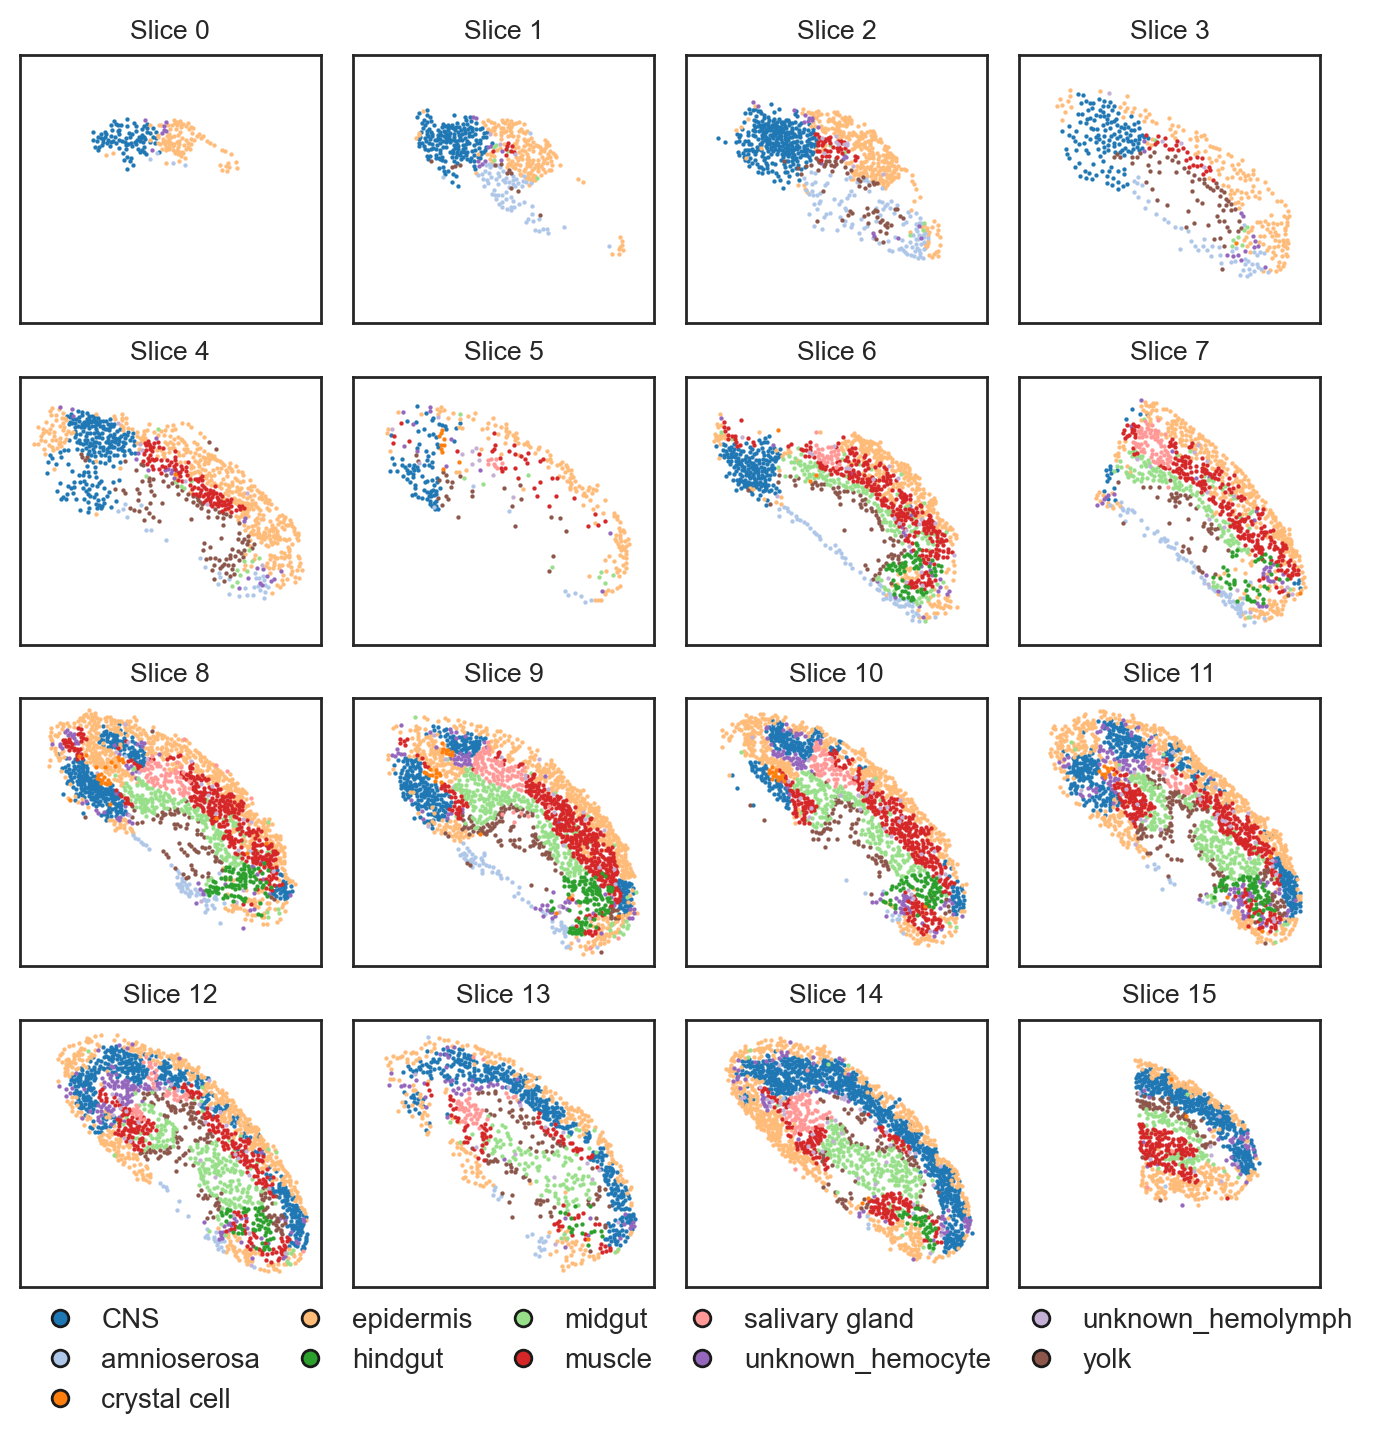

In [119]:
_, palette = st.pl.slices_2d(
    slices = aligned_slices,
    label_key = cluster_key,
    spatial_key = key_added,
    height=2,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -6, 'frameon': False},
    return_palette=True,
)

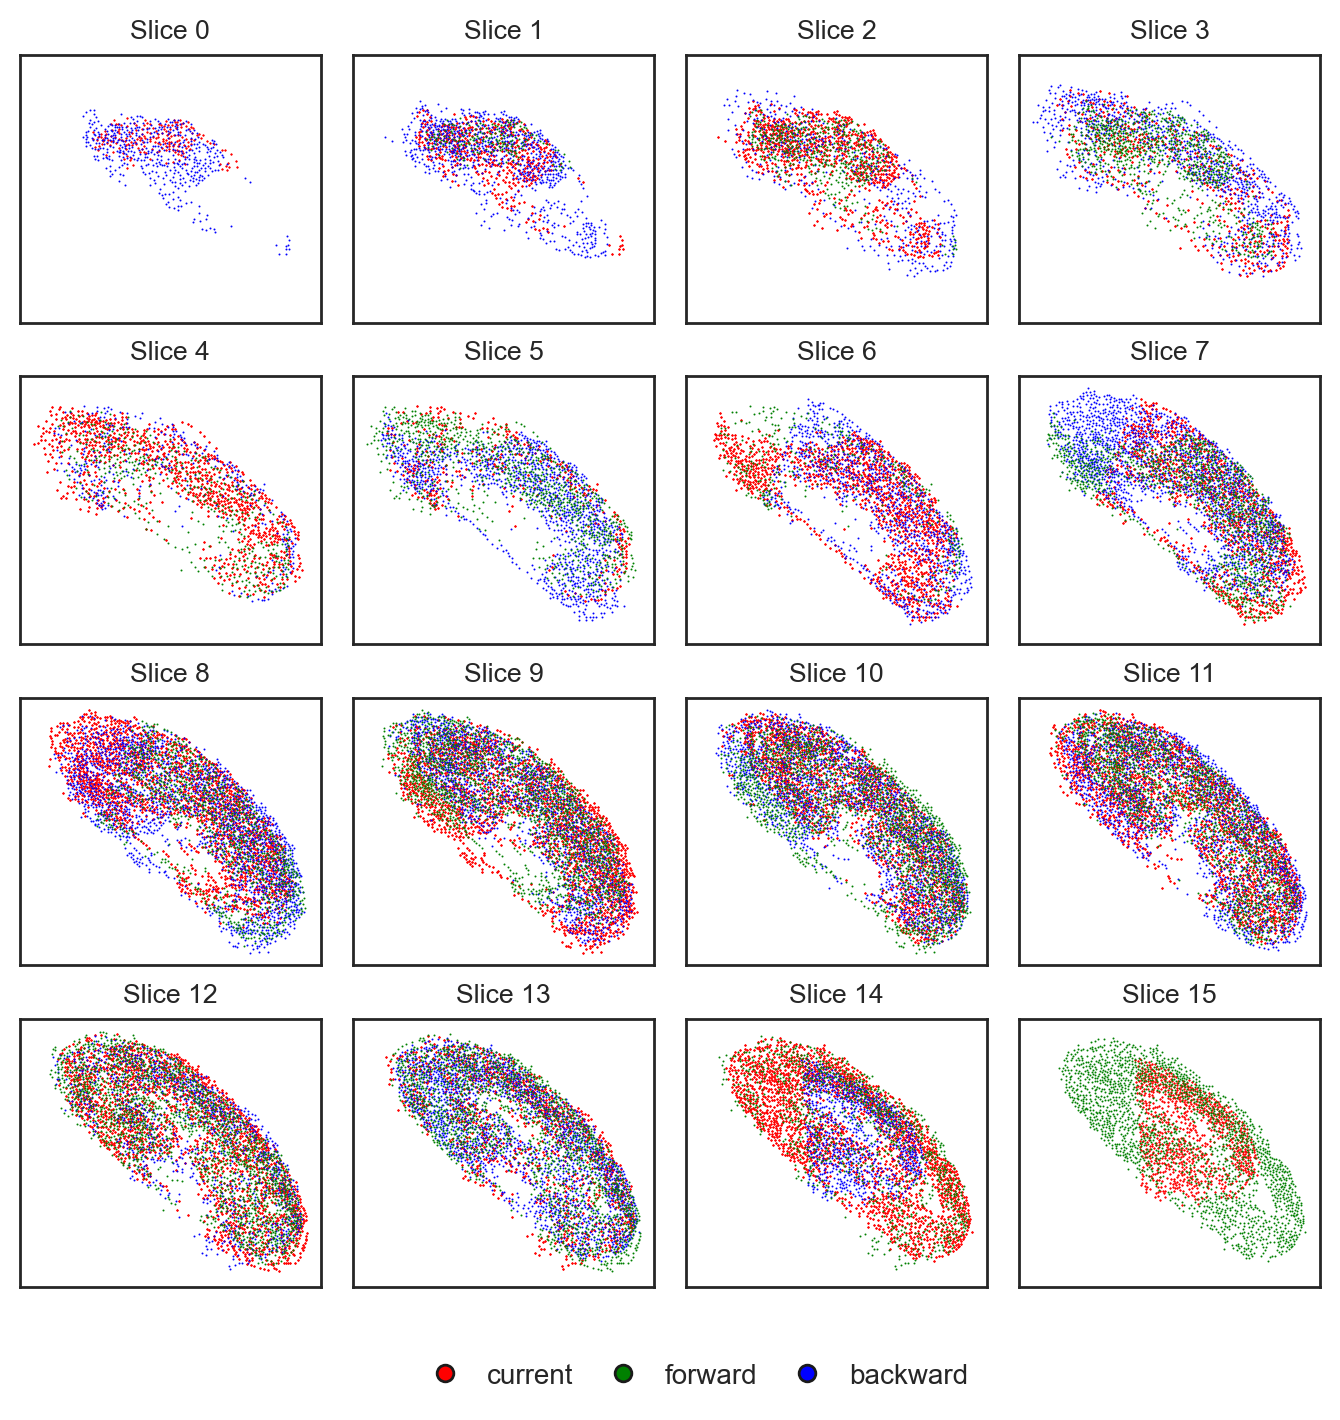

In [114]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=2, overlay_type='both')

It seems that the alignment between slices 14 and 15 is incorrect. Since there is a relatively low partial overlap ratio between slices 14 and 15, we plan to first adjust the parameters related to partial overlap. 

|-----> [Models alignment based on morpho.] in progress: 100.0000%
|-----> [Models alignment based on morpho.] finished [0.8331s]
|-----> [Models alignment based on morpho, applying transformation.] in progress: 100.0000%
|-----> [Models alignment based on morpho, applying transformation.] finished [0.0008s]


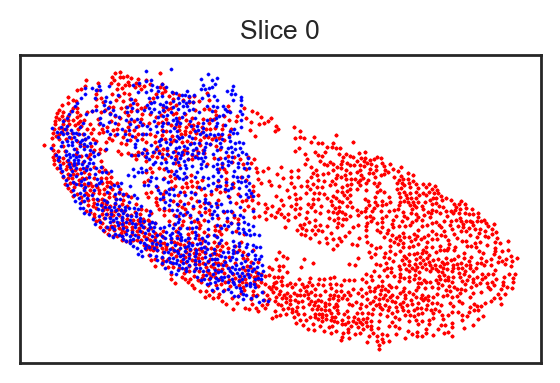

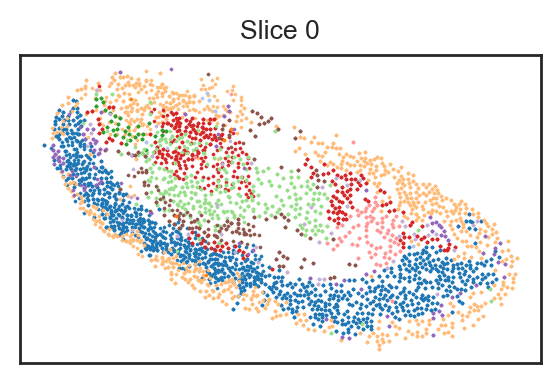

In [145]:
spatial_key = 'spatial'
key_added = 'align_spatial'
cur_idx = 15
slice1 = slices[cur_idx-1].copy()
slice2 = slices[cur_idx].copy()
st.align.group_pca([slice1, slice2], pca_key='X_pca')
cur_transformation = st.align.morpho_align_transformation(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
    SVI_mode=False,
)
cur_aligned_slices = st.align.morpho_align_apply_transformation(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    transformation=cur_transformation,
)
st.pl.overlay_slices_2d(slices = cur_aligned_slices, spatial_key = key_added, height=2, overlay_type='backward', show_legend=False)
st.pl.overlay_slices_2d(slices = cur_aligned_slices, spatial_key = key_added, height=2, overlay_type='backward', label_key=cluster_key, show_legend=False)

We can iteratively adjust the parameters using the above code and check the results. If the results are satisfactory, the problematic transformation can be replaced. Here, we set ``SVI_mode`` to False and found that this produces the correct result. Next, we replace the corresponding rigid transformation as follows:

In [146]:
transformation[cur_idx-1] = cur_transformation[0]

We then apply the updated transformation to all slices.

In [147]:
aligned_slices = st.align.morpho_align_apply_transformation(
    models=slices,
    spatial_key=spatial_key,
    key_added=key_added,
    transformation=transformation,
)

|-----> [Models alignment based on morpho, applying transformation.] in progress: 100.0000%
|-----> [Models alignment based on morpho, applying transformation.] finished [0.0114s]


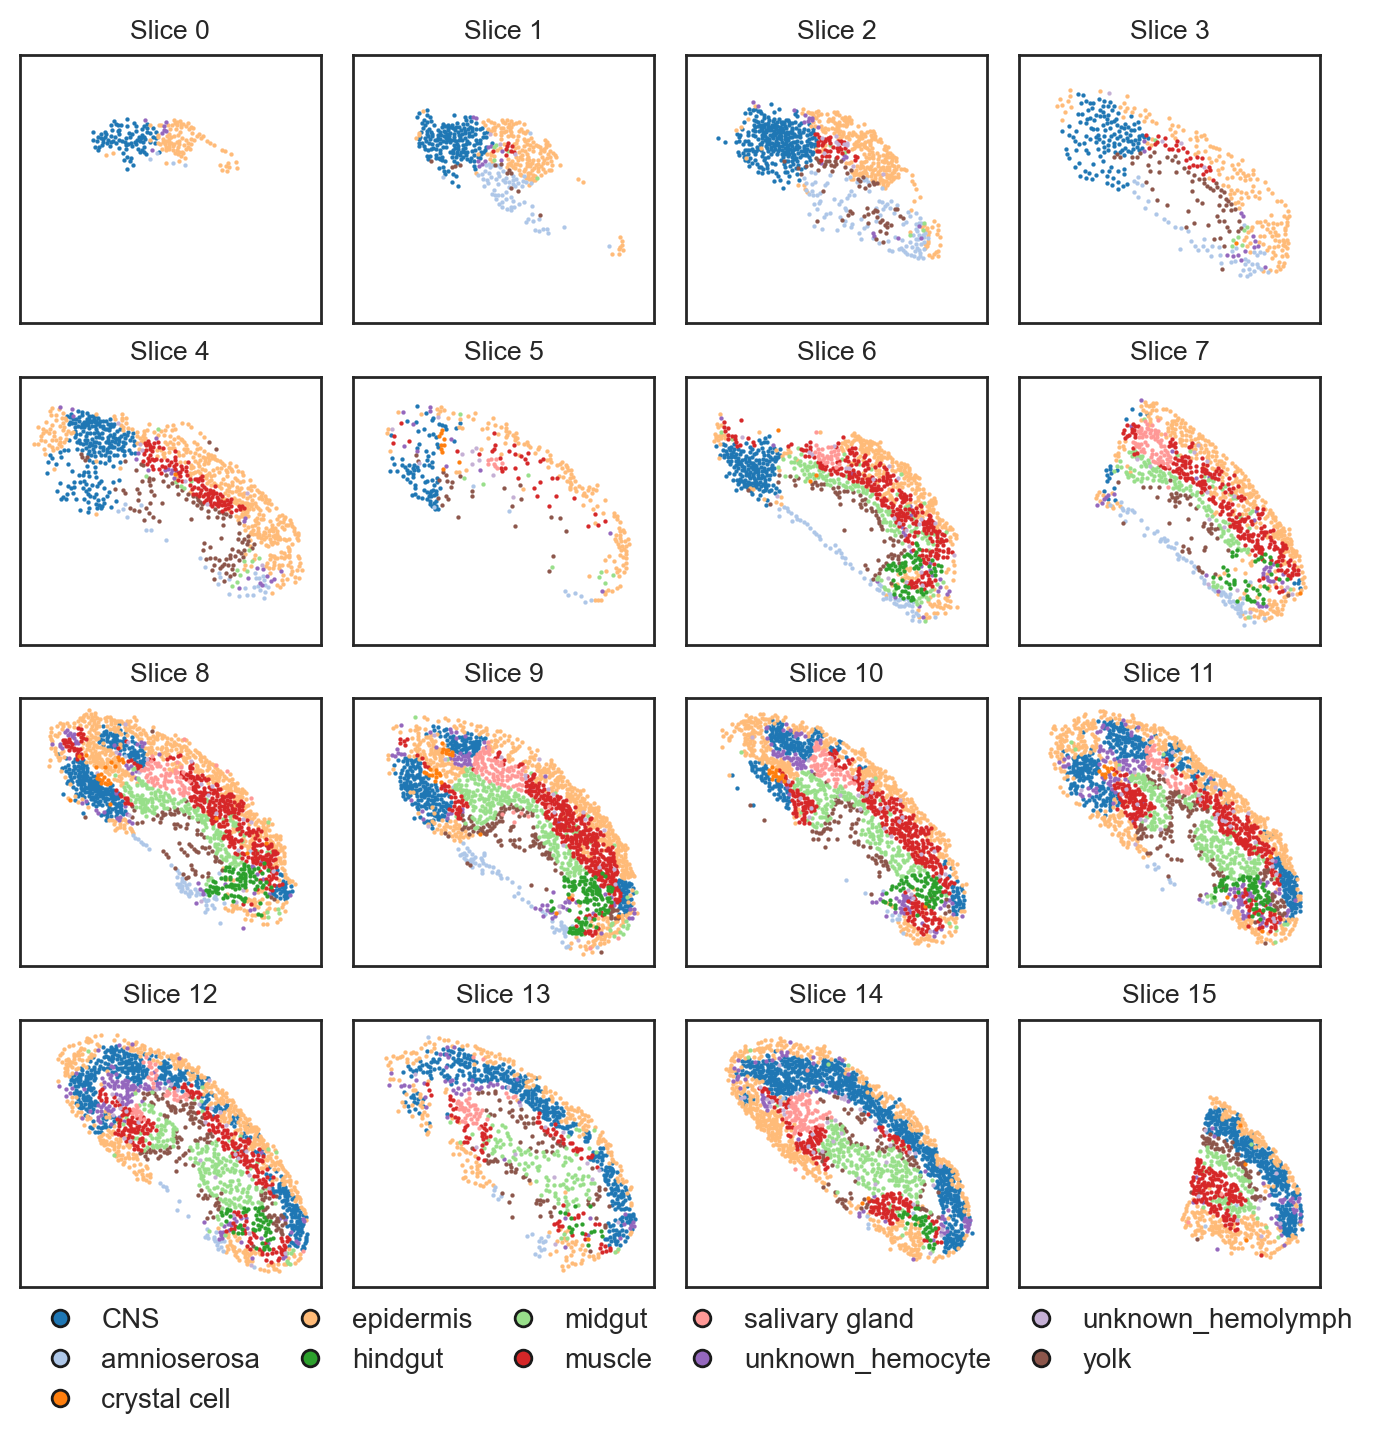

In [148]:
st.pl.slices_2d(
    slices = aligned_slices,
    label_key = cluster_key,
    spatial_key = key_added,
    height=2,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -6, 'frameon': False},
)

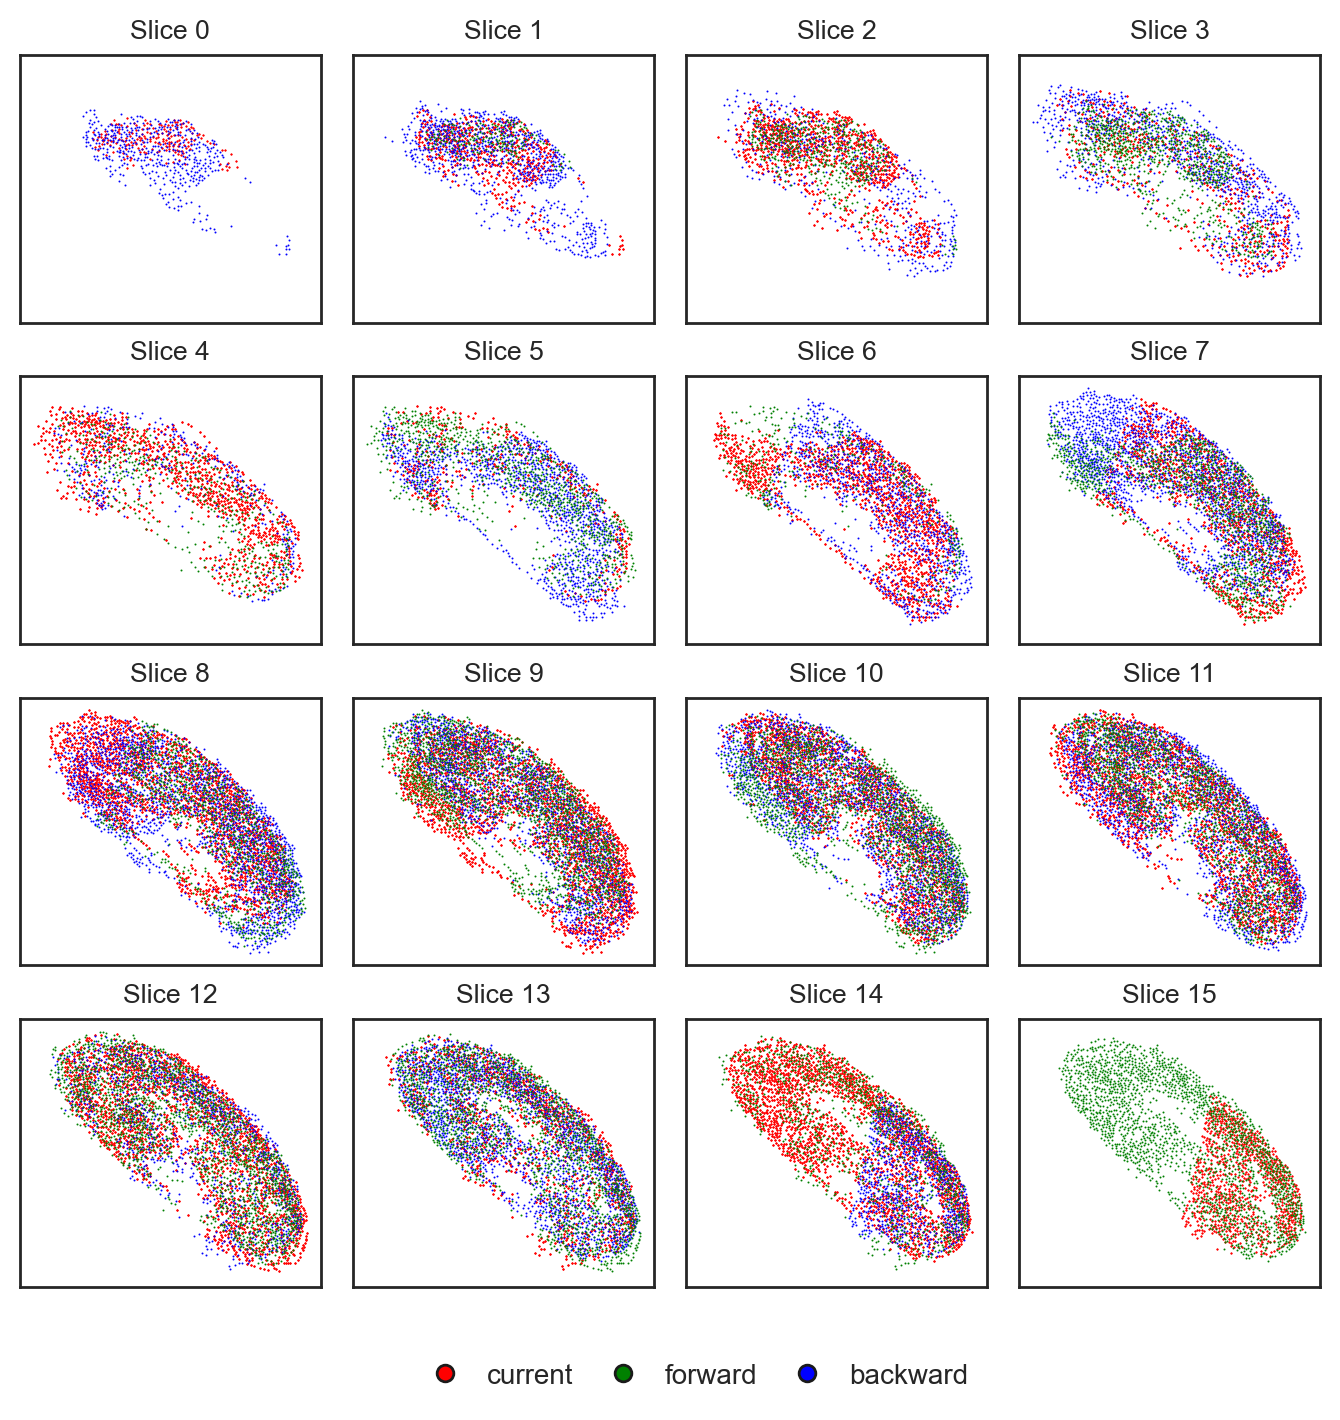

In [154]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=2, overlay_type='both')

## 3D Visualization

In the end, we concatenate the aligned slices and restore the z-axis data to obtain the 3D reconstruction result using pairwise rigid alignment. The 3D visualization is then performed using Spateo's built-in plotting functions.

In [149]:
aligned_adata = ad.concat(aligned_slices)
aligned_adata.obsm['spatial_3D'] = np.concatenate([aligned_adata.obsm['align_spatial'], np.array(aligned_adata.obs['z_height'].values)[:,None]], axis=1)

In [ ]:
# save the results
aligned_adata.write_h5ad('./results/Drosophila_8_9_rigid_alignment.h5ad')

The function st.tdr.construct_pc extracts ``adata.obsm[spatial_key]`` as the 3D coordinates for the point cloud and ``adata.obs[groupby]`` as the labels. It outputs a PyVista data structure and stores ``adata.obs[groupby]`` in ``key_added``. 

In [163]:
point_cloud, _ = st.tdr.construct_pc(adata=aligned_adata,spatial_key="spatial_3D",groupby=cluster_key,key_added="tissue",colormap=palette,)

point_cloud

PolyData (0x7f6944ddd400)
  N Cells:    17996
  N Points:   17996
  N Strips:   0
  X Bounds:   -6.701e+01, 7.980e+02
  Y Bounds:   -3.271e+02, 4.434e+02
  Z Bounds:   1.680e+02, 3.920e+02
  N Arrays:   3

<div class="alert alert-warning">
<strong>Warning:</strong>

The following code block involves [PyVista](https://docs.pyvista.org/) visualization. Before running the PyVista-based visualization function `st.pl.three_d_plot`, please ensure that PyVista is installed correctly, especially for server configurations. Incorrect installation may cause Jupyter Notebook to crash. There are certain specifications to consider when running PyVista on a remote server. We recommend reviewing their [tutorials](https://docs.pyvista.org/user-guide/jupyter/trame.html#remote-jupyter-host), particularly for remote Jupyter environments.
    
</div>

<div class="alert alert-info">
<strong>Tips:</strong>

You can enable interactive visualization by changing the PyVista backend via the jupyter parameter in ``st.pl.three_d_plot``. Setting ``jupyter='static'`` will output a static image. I recommend using ``'html'`` for lightweight interactive visualization. Another very convenient feature is that you can save the interactive 3D visualization as an HTML file by specifying ``plotter_filename`` in ``st.pl.three_d_plot``, making it much easier to share results
    
</div>

``st.pl.three_d_plot`` provides an easy way to visualize 3D plots.

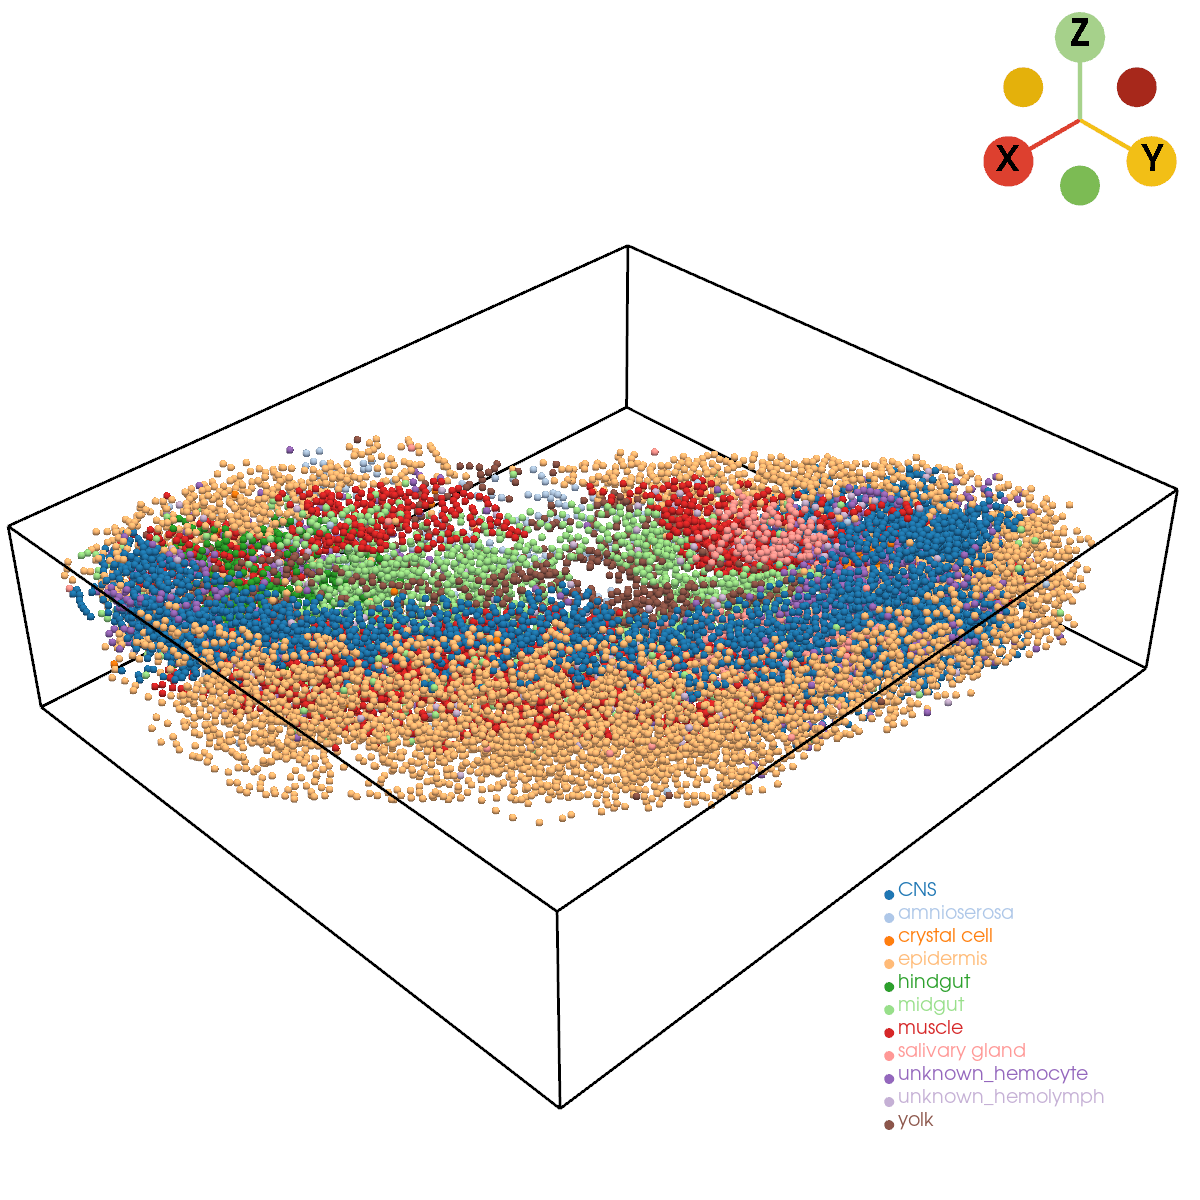

In [162]:
# show the aligned drosophila in 3D
st.pl.three_d_plot(model=point_cloud,key="tissue",model_style='points',model_size=8, show_axes=True,
    jupyter="static",window_size=(1200, 1200),show_outline=True,outline_kwargs={'show_labels': False, 'outline_width': 3},
    # plotter_filename='./results/Drosophila_8_9_rigid_alignment_reconstruction.html',  # uncomment this for saving the interactive 3D visualization
)